STEP 1: Download and Arrange the data
Download the following files on to your PC.

- 2017 train images, 2017 val images, 2017 Train/Val annotations

Some simple re-arrangement and re-naming of folders is required as below. The file structure for the following code is:

Project Folder

└───this code notebook


└───COCOdataset2017   

    └───images
    
    │   └───train
    │   │    │   000000000009.jpg
    │   │    │   000000000025.jpg
    │   │    │   ...
    │   └───val   
    │        │   000000000139.jpg
    │        │   000000000285.jpg
    │        │   ...
    └───annotations
        │   instances_train.json
        │   instances_val.json
        
- for an overview of COCO data structure refer to https://cocodataset.org/#format-data

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
### for go up directory
%cd ..
### to go to directory
%cd ./gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO
%ls

/
/gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO
annotations_trainval2017.zip            train_coco
annotations_trainval2017.zip.1          train_images
cocoapi/                                train.txt
outfile                                 Untitled0.ipynb
Semantic_Segmentation_using_COCO.ipynb  val.txt
train2017.zip


In [12]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [13]:
dataDir='/gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO/cocoapi'
dataType='train'
annFile='{}/annotations/instances_{}2017.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)
for cat in cats:
  print(cat['id'],'.\t', cat['name'])

loading annotations into memory...
Done (t=28.77s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, '

In [14]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"


print('The class name is', getClassName(77, cats))

The class name is cell phone


In [ ]:
# Get number of images
print("Number of images :", len(set(coco.getImgIds())))

Number of images : 118287


Number of images containing all the  classes: 238


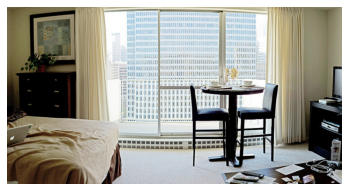

In [ ]:
########## UNIQUE COMBINATION ########
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['laptop', 'tv', 'cell phone']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}2017/{}'.format(dataDir,dataType,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

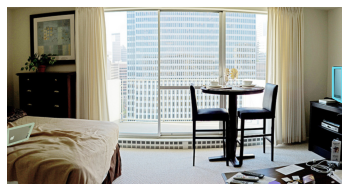

In [ ]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)    # pycoco functionalities “loadAnns” to load the annotations concerning the object in COCO format
coco.showAnns(anns)  # “showAnns” to sketch annotations out on the image

In [ ]:
########## Class Filtering: ALl POSSIBLE COMBINATIONS ########
classes = ['laptop', 'tv', 'cell phone']

images = []
if classes!=None:
    # iterate for each individual class in the list
    for className in classes:
        # get all images containing given class
        catIds = coco.getCatIds(catNms=className)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
else:
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    
# Now, filter out the repeated images    
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 10903


## Normal Mask
In the mask created below, each pixel has a label according to the class it falls into.

For example,
0: background
1: laptop
2: tv
3: cell phone

Note: not using the official COCO ids, but instead allotting pixel values as per the order of the class name in the array 'filterClasses'.

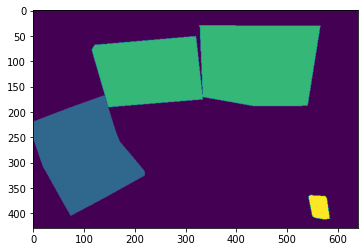

In [ ]:
#### GENERATE A SEGMENTATION MASK (MULTICLASS) ####
filterClasses = ['laptop', 'tv', 'cell phone']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

## Binary Masking
In general, your output mask will N possible pixel values for N output classes. However, binary masking implies that the output mask will have only 2 pixel values, i.e., 0 will represent the background and 1 will represent the objects.

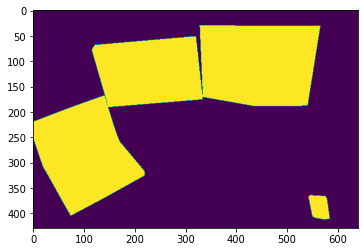

In [ ]:
#### GENERATE A BINARY MASK (BINARY CLASSES) ####
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)   # highest value between 1 (object class) and 0 (mask)
plt.imshow(mask)

# Image Filtering function
The function takes 3 inputs —
(a) folder: the folder containing the COCO dataset
(b) classes: None OR a list object containing desired output classes
(c) mode: ‘train’ OR ‘val’
This function first loads and initiates the pycoco object. Then all possible combinations of “classes” are taken. If no filter classes are given, it loads the entire dataset. Since some images may contain two or more of the output classes, there might be repeat images in our images variable. So we iterate through it and filter out the unique images. Finally, we shuffle the unique image list and return it along with some other useful data.

FilterDataset function inputs:
- folder: the folder containing the dataset
- classes: a list object if you want specific output classes or None
- mode: 'train' or 'val'

The function returns:
- images: a list containing all the filtered image objects
- dataset_size: The size of the generated filtered dataset
- coco: The initialized coco object

In [15]:
from tqdm import tqdm

def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}2017.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in tqdm(range(len(images))):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [19]:
# create generator objects (one for train and one for val)
folder = '/gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO/cocoapi'
classes = ['laptop', 'tv', 'cell phone']
mode = 'val'

val_images, val_dataset_size, val_coco = filterDataset(folder, classes, mode)

loading annotations into memory...


100%|██████████| 604/604 [00:00<00:00, 74712.74it/s]

Done (t=1.70s)
creating index...
index created!


In [ ]:
print('selected categories: ', classes)
print("validation dataset size: ", val_dataset_size)
print('validation selected images : ', val_images)
print('annotation file instantiated: ', val_coco)

selected categories:  ['laptop', 'tv', 'cell phone']
validation dataset size:  503
validation selected images :  [{'license': 2, 'file_name': '000000131138.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000131138.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-15 16:32:36', 'flickr_url': 'http://farm6.staticflickr.com/5258/5517114538_91f825ecdf_z.jpg', 'id': 131138}, {'license': 1, 'file_name': '000000214869.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000214869.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-15 20:33:29', 'flickr_url': 'http://farm3.staticflickr.com/2243/1900976427_3bf763653a_z.jpg', 'id': 214869}, {'license': 4, 'file_name': '000000343149.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000343149.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-22 17:03:46', 'flickr_url': 'http://farm9.staticflickr.com/8528/8451405956_8c88c54606_z.jpg', 'id': 343149}, {'license': 4, 'file_name': '00000000126

In [ ]:
# To create a set of unfiltered images covering whole TRAIN dataset (LONG TIME TO RUN)
folder = '/gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO/cocoapi'
classes = None
mode = 'train'

train_images, train_dataset_size, train_coco = filterDataset(folder, classes, mode)

loading annotations into memory...
Done (t=17.11s)
creating index...




  0%|          | 0/118287 [00:00<?, ?it/s]

  2%|▏         | 2057/118287 [00:00<00:05, 20558.21it/s]

index created!


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

 56%|█████▌    | 66122/118287 [03:45<06:25, 135.39it/s]

 56%|█████▌    | 66136/118287 [03:45<06:25, 135.36it/s]

 56%|█████▌    | 66150/118287 [03:45<06:27, 134.63it/s]

 56%|█████▌    | 66164/118287 [03:45<06:26, 134.71it/s]

 56%|█████▌    | 66178/118287 [03:45<06:24, 135.38it/s]

 56%|█████▌    | 66192/118287 [03:45<06:23, 135.69it/s]

 56%|█████▌    | 66206/118287 [03:45<06:23, 135.72it/s]

 56%|█████▌    | 66220/118287 [03:46<06:24, 135.48it/s]

 56%|█████▌    | 66234/118287 [03:46<06:23, 135.73it/s]

 56%|█████▌    | 66248/118287 [03:46<06:21, 136.43it/s]

 56%|█████▌    | 66263/118287 [03:46<06:16, 138.21it/s]

 56%|█████▌    | 66277/118287 [03:46<06:18, 137.47it/s]

 56%|█████▌    | 66291/118287 [03:46<06:23, 135.48it/s]

 56%|█████▌    | 66305/118287 [03:46<06:20, 136.60it/s]

 56%|█████▌    | 66319/118287 [03:46<06:20, 136.46it/s]

 56%|█████▌    | 66333/118287 [03:46<06:24, 135.18it/s]

 56%|████

In [ ]:
# SAVE WHOLE TRAINING SET NO FILTER FOR LATER USE AS IT TAKES LONG TIME TO PRODUCE
import pickle
with open('train_images', 'wb') as fp:
  pickle.dump(train_images, fp)
with open('train_coco', 'wb') as fp:
  pickle.dump(train_coco, fp)
                
print(len(train_dataset_size))

In [16]:
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

# function dataGeneratorCoco
Inputs :
- images: the image list returned by the filterDataset function
- classes: the filter classes list same as input to the filterDataset function
- coco: the coco object returned by the filterDataset function
- folder: the folder containing the dataset
- input_image_size: size of input image to your model as (width, height)
- batch_size: batch size
- mode: ‘train’ or ‘val’ same as input to the filterDataset function
- mask_type: ‘binary’ or ‘normal’(classes can’t be None)

In [17]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}2017'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):                        # will yield batches indefinitely while called from an iteration loop (training)
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img           # index between 0 and batch_size, batch of images renewed with each yield operation
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size): # reset to the start of dataset before the end of the dataset
            c=0                 
            random.shuffle(images)
        yield img, mask

In [26]:
##### PRELOAD EXISTING FILTERDATASET FOR TRAIN SET IF ANY - DO NOT RUN OTHERWISE
import pickle

with open ('/gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO/train_images', 'rb') as fp:
  train_images = pickle.load(fp)

with open ('/gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO/train_coco', 'rb') as fp:
  train_coco = pickle.load(fp)

In [27]:
print(len(train_images))

118287


In [69]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'normal'
mode = 'train'
classes = ['oven', 'cat', 'keyboard', 'laptop', 'clock', 'person', 'bed', 'cup','dining table', 'sink', 'fork', 'knife', 'spoon', 'cell phone']

#### UNMARK BELOW LINES TO USE PREEXISTING FILTER (then MARK THE 3rd line instead)
#images = train_images
#coco = train_coco
images, dataset_size, coco = filterDataset(folder, classes, mode)

gen = dataGeneratorCoco(images, classes, coco, folder, 
                            input_image_size, batch_size, mode, mask_type)

In [67]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


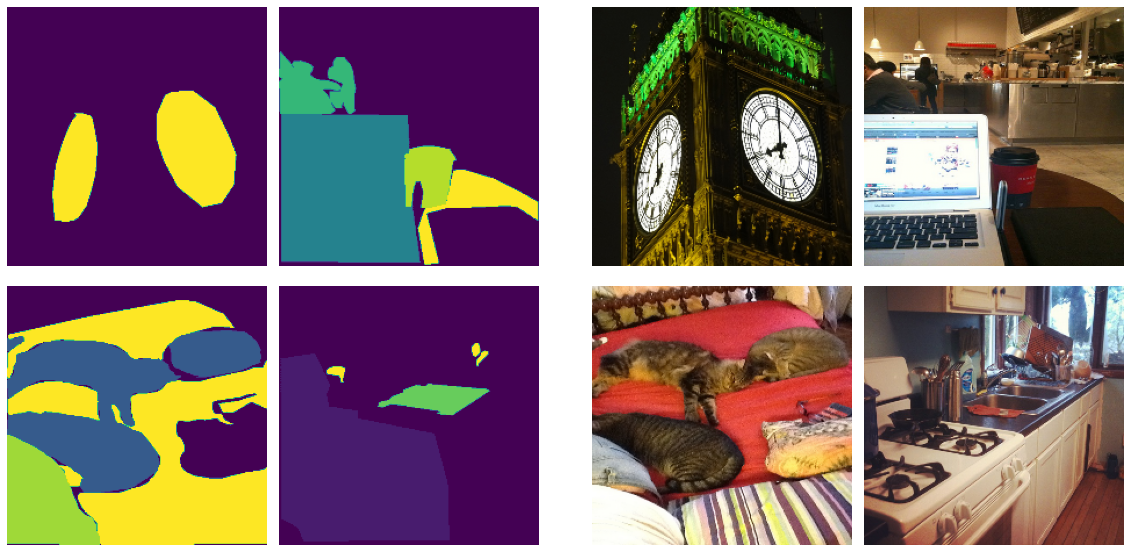

In [70]:
visualizeGenerator(gen)

In [23]:
os.path.exists('/gdrive/My Drive/Colab Notebooks/Semantic_segmentation_with_COCO/cocoapi/images/train2017/000000479941.jpg')

False

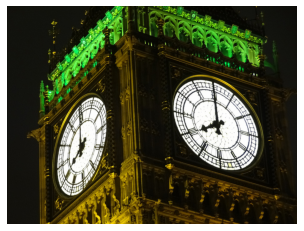

In [35]:
I = io.imread('{}/images/{}2017/{}'.format(folder,mode,'000000479941.jpg'))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

# DATA AUGMENTATION inputs
- gen: the generator object to which you wish to add augmentations
- augGeneratorArgs: the augmentation arguments for Keras ImageGenerator
- seed: seed to generate the random augmentation parameters or None

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        mask_aug = next(g_y)
                   
        yield img_aug, mask_aug

#### The output of the function is a data generator object yielding batches of augmented images and correspondingly augmented binary masks

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

# Call the function with the arguments
aug_gen = augmentationsGenerator(gen, augGeneratorArgs)

In [ ]:
visualizeGenerator(aug_gen)

# Train section
- Requires Train and Val datasets using filterDataset() with or without predefined categories (filtering)
- Requires Train and Val data generators using dataGeneratorCoco()

In [ ]:
# Set your parameters
n_epochs = <number of epochs of training>
steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size
m = <your model>
opt = <your optimizer>
lossFn = <your loss function>
# Compile your model first
m.compile(loss = lossFn, optimizer = opt, metrics=['accuracy'])
# Start the training process
history = m.fit(x = train_gen_aug,
                validation_data = val_gen_aug,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose = True)